# Delta Search


In [1]:
from __future__ import print_function

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import histdata
import json
import os
import copy

from IPython import display
%matplotlib inline
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

mp = load_json("/project/exp/list_mp.json")

h5 = histdata.get_pandadb()
df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]

start, end = "2016-05-01 01:15:00" , "2016-06-13 04:55:00"

In [2]:
print("ok")

ok


In [4]:
!pip install distributed
!pip install singledispatch

Cleaning up...
Cleaning up...


In [5]:
from apscan import builder

from trading import dataprovider
import datetime
import pytz

In [6]:
# from apscan.stockdata import Symbols
from apscan.stockdata.us import UsSymbols
uss = UsSymbols()
# UsSymbols.download(uss)
symbol_list = pd.read_csv(uss.SYMBOL_FILE)
symbols = symbol_list["Symbol"].values

In [7]:
# cli = dataprovider.DataClient("EURUSD", "5Min")
# cli.querydf(start,end)

# cli = dataprovider.get_client('EURUSD', '1H')
# cli.querydf(datetime.datetime.strptime(start,"%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.utc),
#             datetime.datetime.strptime(end,"%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.utc))

In [7]:
start, end = "2016-05-10 01:15:00" , "2016-05-10 04:55:00"
d_start = datetime.datetime.strptime(start,"%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.utc)
d_end = datetime.datetime.strptime(end,"%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.utc)
builder.task_download('us',"GOOGL",d_end, days=300)

('GOOGL',                   Open        High         Low       Close    Volume
 Date                                                                
 2015-07-15  583.739990  588.690002  580.210022  583.960022   2073300
 2015-07-16  589.500000  604.500000  587.919983  601.780029   5632100
 2015-07-17  680.000000  703.000000  678.000000  699.619995  12858100
 2015-07-20  688.979980  697.799988  681.770020  692.840027   5121800
 2015-07-21  684.880005  705.599976  684.150024  695.349976   3780200
 2015-07-22  694.020020  713.330017  691.619995  695.099976   4155000
 2015-07-23  691.849976  696.070007  671.590027  674.729980   3811600
 2015-07-24  676.770020  677.789978  653.179993  654.770020   4131100
 2015-07-27  651.570007  667.070007  651.549988  658.270020   2919100
 2015-07-28  661.760010  664.099976  653.409973  659.659973   1718200
 2015-07-29  662.260010  663.330017  652.840027  661.429993   1837800
 2015-07-30  657.440002  668.049988  651.690002  664.559998   1980300
 2015-07-31

In [8]:
# os.system("/project/python/lib/apscan/csp.py")
# from apscan.csp import *
import apscan.csp as csp
from apscan import stockdata

In [9]:
# !cat /project/python/lib/apscan/csp.py

In [10]:
from apscan.stockdata import EodData

eod = EodData('us')

eod.download_from_s3()

In [11]:
!pip install joblib

In [12]:
def search_latest_n(region, symbol, timeframe, num_candles,
                    multiprocess=True, invert=False):

    assert num_candles >= 4

    if timeframe != '1D' or region not in ('us', 'jp'):
        raise ValueError('Unsupported Params')

    with stockdata.EodData(region) as eod:

        symbols = stockdata.Symbols.get(region).symbols.keys()

        # rule
        try:
            rule = [
                csp.get_bmp(symbol, timeframe, offset, eod.db[symbol])
                for offset in range(
                    len(eod.db[symbol]) - num_candles,
                    len(eod.db[symbol]) - 3)]
        except KeyError as e:
            logger.exception(e)
            return []

        # Compute range vector
        df = eod.db[symbol]
        offset = len(df) - num_candles
        candles_query = df.ix[offset:][['Open', 'High', 'Low', 'Close']]
        range_query = candles_query.apply(csp.candle_range, axis=1)
        close_query = candles_query['Close'].values

        # search
        ret = []

        if multiprocess:
            from joblib import Parallel, delayed
            ret = Parallel(n_jobs=24)(
                delayed(csp._calc_score)(
                    s, timeframe, eod.db[s], rule, num_candles,
                    range_query, close_query, invert=invert)
                for s in symbols if s in eod.db)
        else:
            ret = [
                csp._calc_score(s, timeframe, eod.db[s], rule, num_candles,
                            range_query, close_query, invert=invert)
                for s in symbols if s in eod.db]

        # order by score and having query symbol in the top
        ret = sorted(
            filter(lambda x: x, ret),
            key=lambda x: x[1] if x[0] != symbol else 2.0,
            reverse=True)

    return ret

In [13]:
# df = eod.db

In [73]:
%%time
ret = search_latest_n(region="us",
               symbol="DTE",
               timeframe="1D",
               num_candles=60)

CPU times: user 44.6 s, sys: 3.74 s, total: 48.3 s
Wall time: 45.9 s


In [ ]:
start, end = "2016-05-10 01:15:00" , "2016-05-10 04:55:00"
d_start = datetime.datetime.strptime(start,"%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.utc)
d_end = datetime.datetime.strptime(end,"%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.utc)
builder.task_download('us',"GOOGL",d_end, days=300)

QUERY


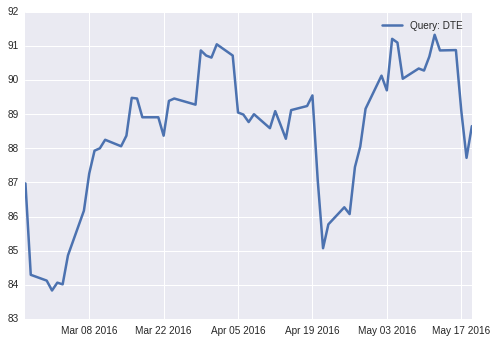

********************************************************************************


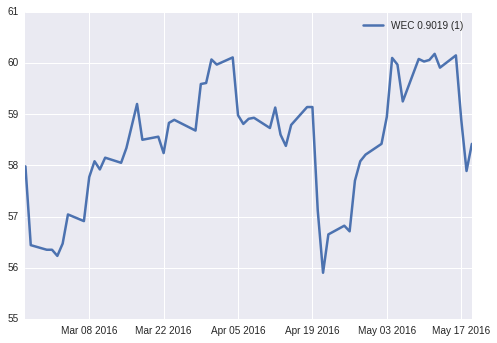

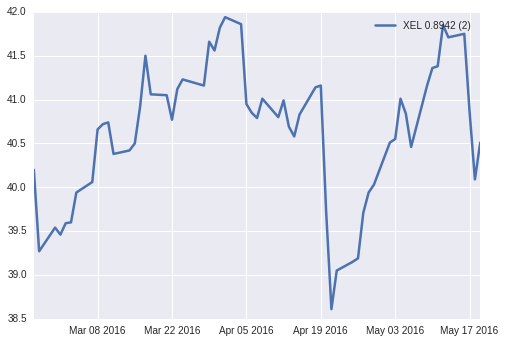

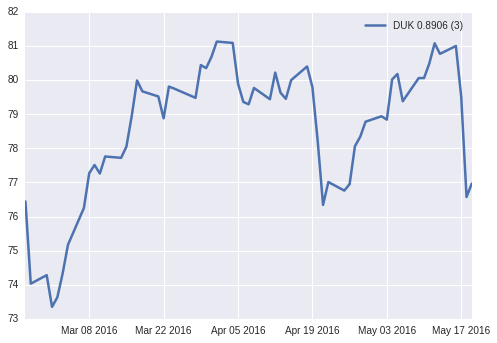

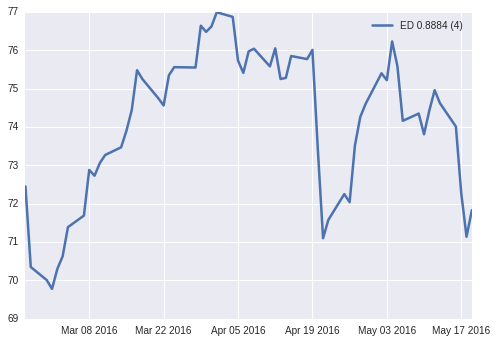

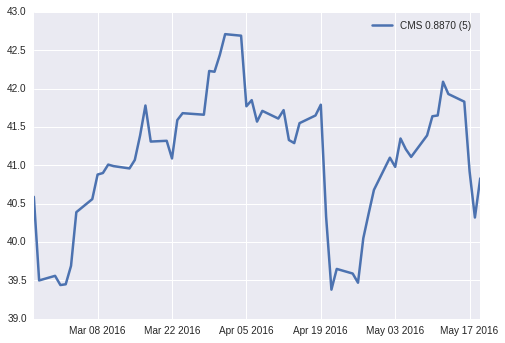

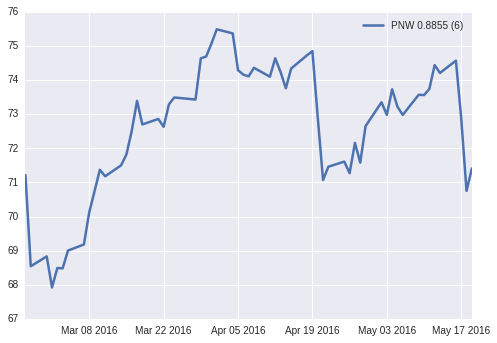

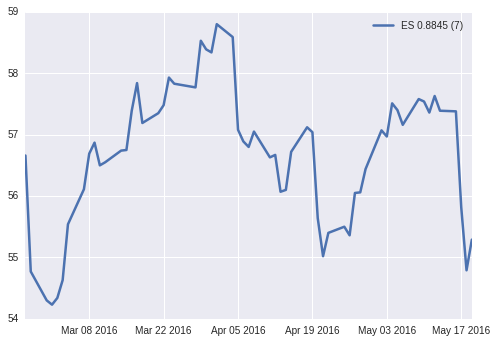

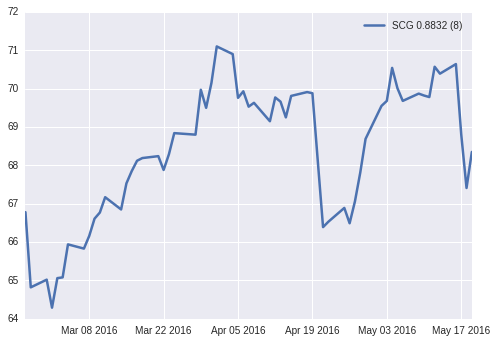

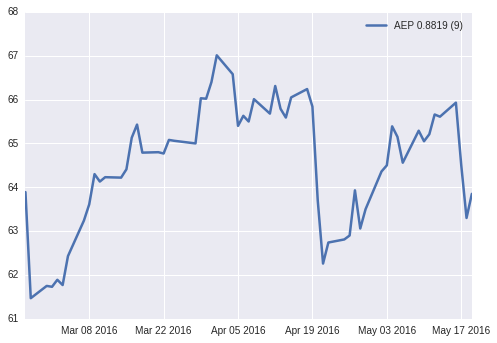

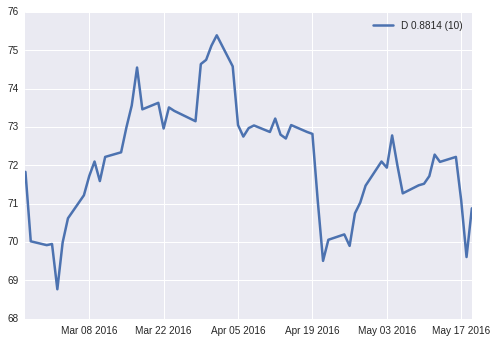

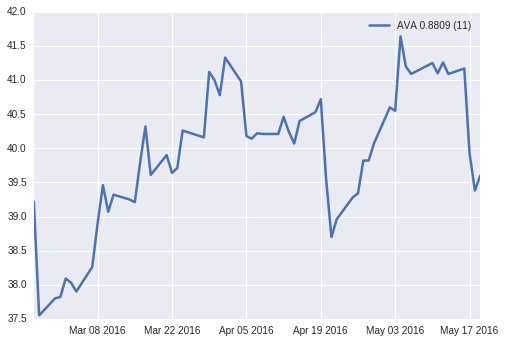

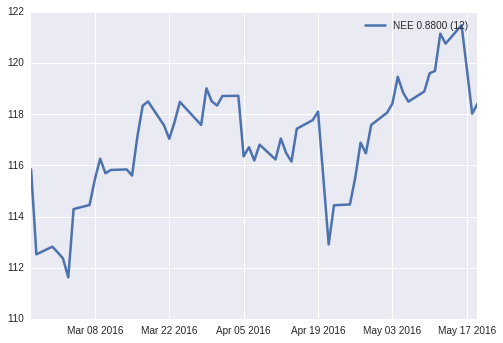

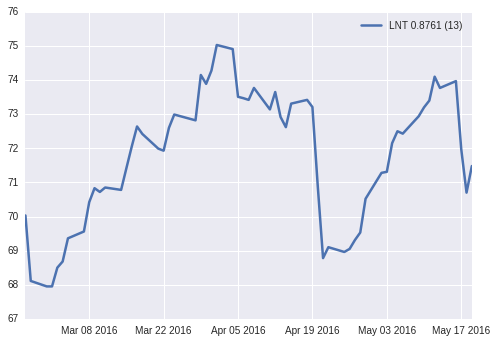

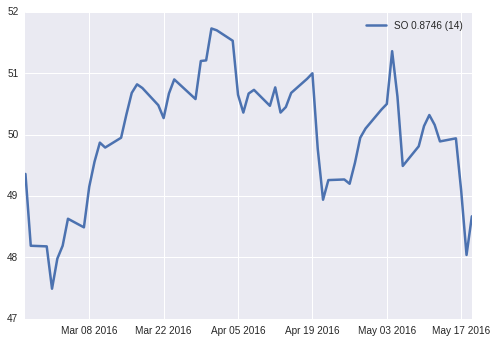

In [69]:
print("QUERY")
x = eod.db[ret[0][0]][ret[0][2]:ret[0][3]]["Close"]
plt.plot(x,label="Query: %s" %(ret[0][0]))
plt.legend()
plt.show()
print("*"*80)
for idxi,i in enumerate(ret[1:15]):
    x = eod.db[i[0]][i[2]:i[3]]["Close"]
    plt.plot(x,label="%s %0.4f (%d)" %(i[0],i[1],idxi+1))
    plt.legend()
    plt.show()
# plt.show()

In [14]:
def generate_dataset(stock_names,num_candles=60,take_n_firsts=100):
    dataset = {}
    for i in stock_names:
        print("Searching through %s..."%i, end=" ")
        ret = search_latest_n(region="us",
                       symbol=i,
                       timeframe="1D",
                       num_candles=num_candles)
        if len(ret)==0:
            print(u"\x1b[31mSkipped ✘\x1b[0m",end="\n")
            continue
        print(u"\x1b[32mDone ✔\x1b[0m",end="\n")
        for i in ret[:take_n_firsts]:
            try:
                dataset[i[0]]
            except KeyError:
                dataset[i[0]] = [i[2],i[3]]
    return dataset

In [15]:
def filter_dataset(dataset):
    for idxi,i in enumerate(dataset.keys()):
        display.clear_output()
        d = dataset[i]
        x = eod.db[i][d[0]:d[1]]["Close"]
        plt.plot(x,label="%s (%d)" %(i,idxi))
        plt.legend()
        plt.show()
        print()
        s = raw_input(" Delete / Keep   (Quit) : d / k   (q)\n")
        s.lower()
        if s == "q":
            print("> Quit")
            print("Nb elements in the dataset:",len(dataset.keys()))
            return
        elif s == "d":
            dataset.pop(i,None)
            print("> Deleted")
        else:
            print("> Kept")
    print("Finished\nNb elements in the dataset:",len(dataset.keys()))

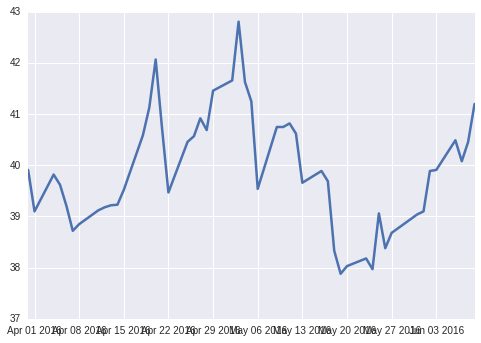

In [16]:
plt.plot(eod.db["AWR"][-50:]["Open"])
plt.show()

In [16]:
with open("/jupyter/data/triangledescending.pkl","rb") as f:
    triangledescending = pickle.load(f)
with open("/jupyter/data/headandshoulders.pkl","rb") as f:
    headandshoulders = pickle.load(f)

In [93]:
%%time
# http://elite.finviz.com/screener.ashx?v=211&s=ta_p_doubletop&ty=l&ta=0&o=sigrow
# double top
doubletop = generate_dataset(["DTE","LNT","ATO","VVC","CMS"],num_candles=50,take_n_firsts=10)

Searching through DTE... Done ✔
Searching through LNT... Done ✔
Searching through ATO... Done ✔
Searching through VVC... Done ✔
Searching through CMS... Done ✔
CPU times: user 3min 29s, sys: 17.2 s, total: 3min 46s
Wall time: 3min 37s


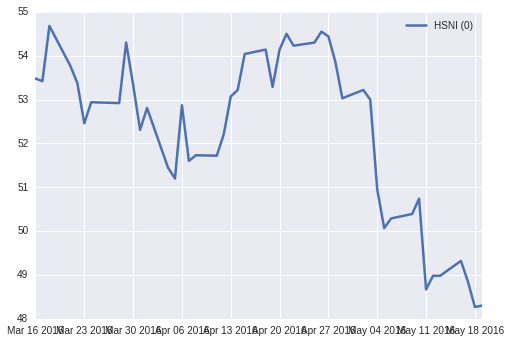

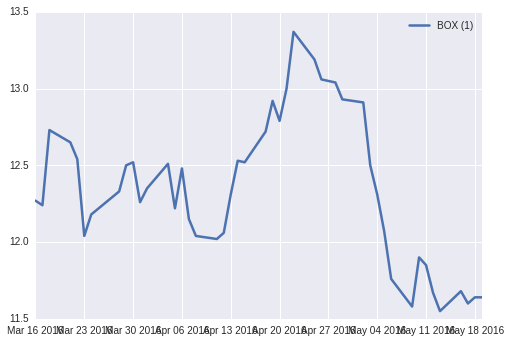

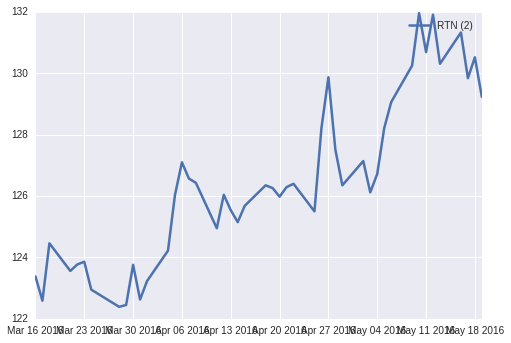

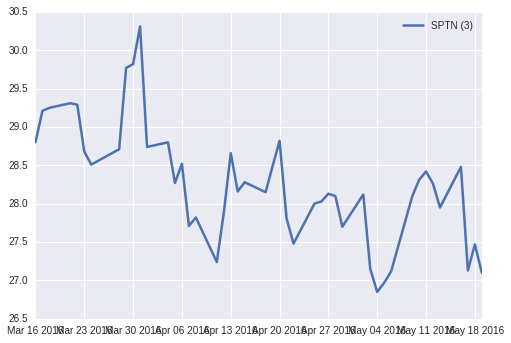

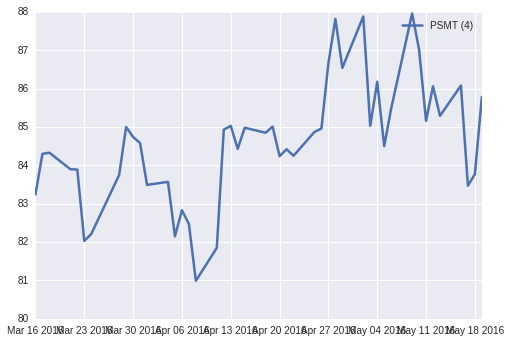

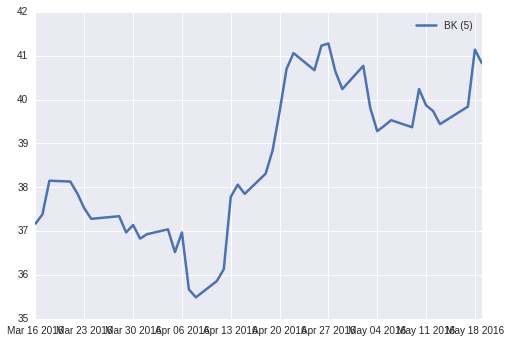

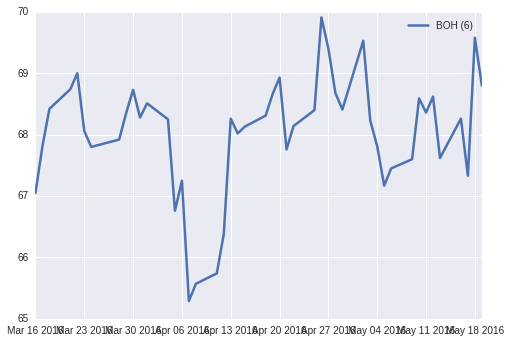

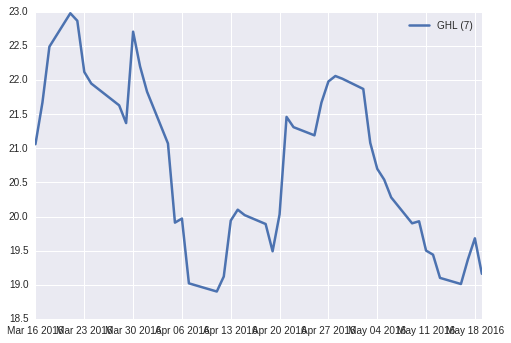

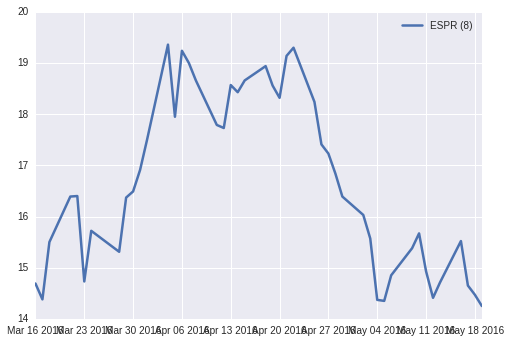

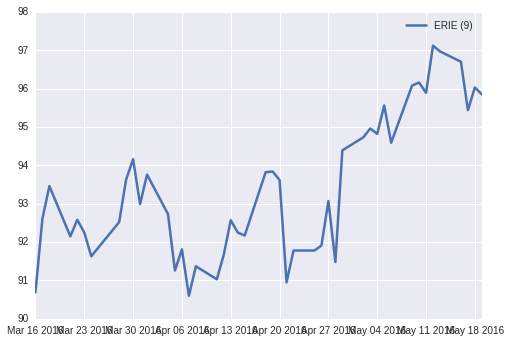

In [69]:
for idxi,i in enumerate(triangledescending.keys()[:5]):
    d = triangledescending[i]
    x = eod.db[i][d[0]:d[1]]["Close"]
    plt.plot(x,label="%s (%d)" %(i,idxi))
    plt.legend()
    plt.show()

In [62]:
%%time
# http://elite.finviz.com/screener.ashx?v=211&s=ta_p_wedgesupport&ta=0
# triangle descending
triangledescending = generate_dataset(["IPCC","DAVE","GHL","PST","CEV"],num_candles=50,take_n_firsts=10)

Searching through IPCC... Done ✔
Searching through DAVE... Done ✔
Searching through GHL... Done ✔
Searching through PST... Skipped ✘
Searching through CEV... Done ✔
CPU times: user 2min 56s, sys: 15.4 s, total: 3min 11s
Wall time: 3min 5s


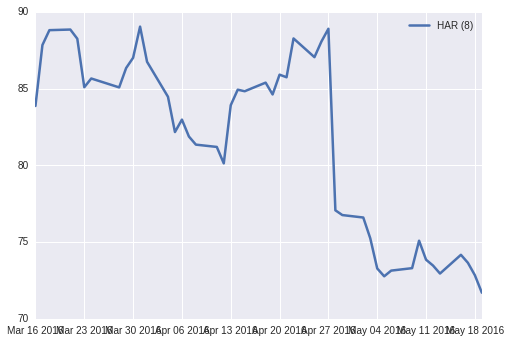


 Delete / Keep   (Quit) : d / k   (q)
q
> Quit


In [115]:
filter_dataset(triangledescending)

In [18]:
len(triangledescending.keys())

53

In [19]:
# with open("/jupyter/data/triangledescending.pkl","wb") as f:
#     pickle.dump(triangledescending,f)
# with open("/jupyter/data/headandshoulders.pkl","wb") as f:
#     pickle.dump(headandshoulders,f)

In [21]:
%%time
# http://elite.finviz.com/screener.ashx?v=211&s=ta_p_wedgesupport&ta=0
# triangle descending
headandshoulders = generate_dataset(["RST","AWR"],num_candles=50,take_n_firsts=30)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 37 µs


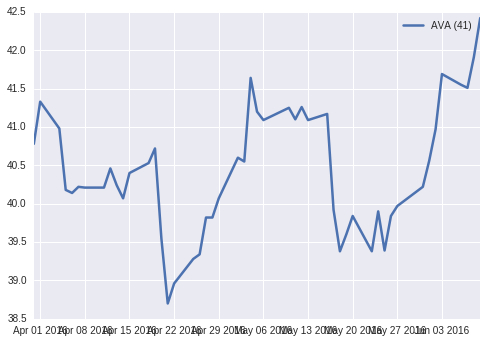


 Delete / Keep   (Quit) : d / k   (q)
d
> Deleted
Finished
Nb elements in the dataset: 7


In [27]:
filter_dataset(headandshoulders)

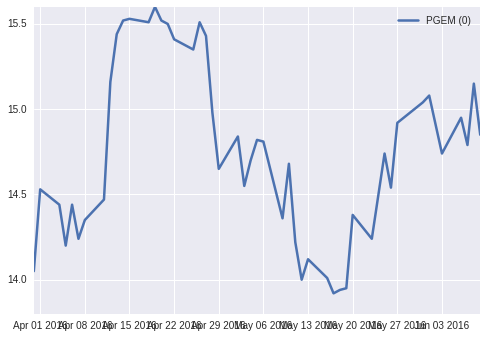

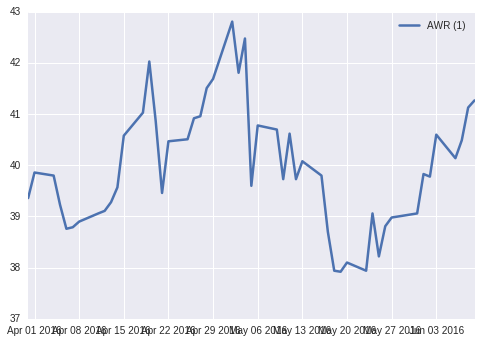

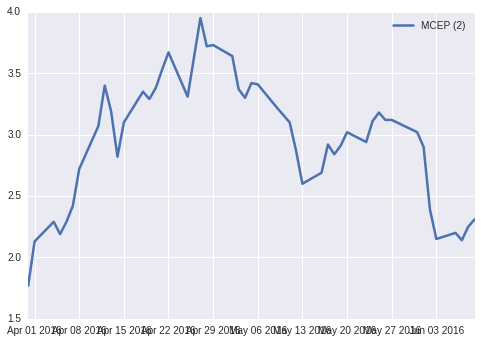

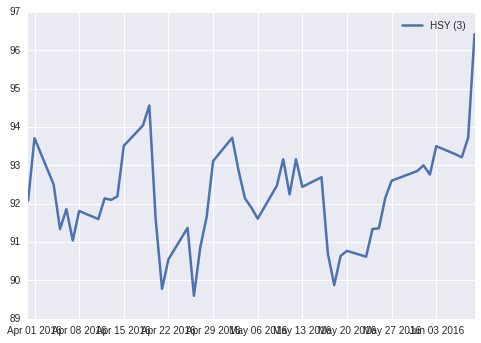

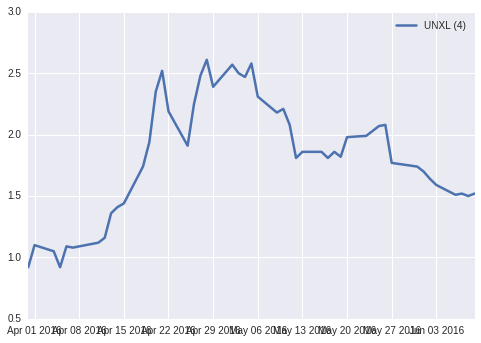

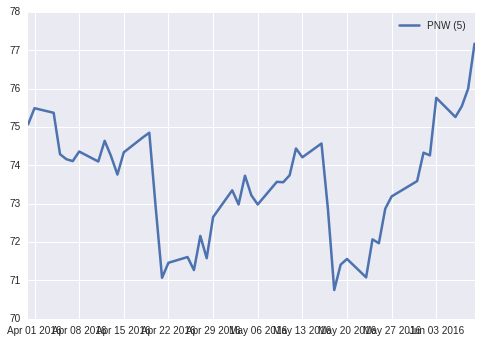

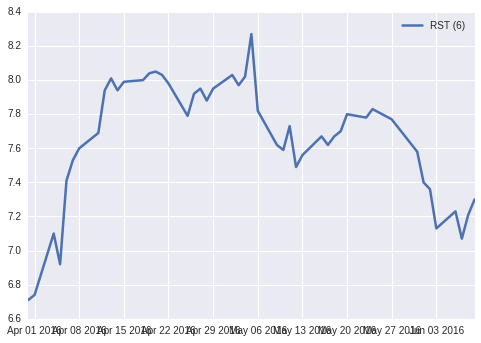

In [31]:
for idxi,i in enumerate(headandshoulders.keys()):
    d = headandshoulders[i]
    x = eod.db[i][d[0]:d[1]]["Close"]
    plt.plot(x,label="%s (%d)" %(i,idxi))
    plt.legend()
    plt.show()

In [23]:
headandshoulders

{'AC': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09 00:00:00')],
 'AIZ': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09 00:00:00')],
 'ALE': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09 00:00:00')],
 'AMSC': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09 00:00:00')],
 'AP': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09 00:00:00')],
 'APA': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09 00:00:00')],
 'ATO': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09 00:00:00')],
 'AVA': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09 00:00:00')],
 'AVGR': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09 00:00:00')],
 'AWK': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09 00:00:00')],
 'AWR': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09 00:00:00')],
 'BCC': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09 00:00:00')],
 'BKD': [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-09

# 1D Convolution
I simply adapt the kernel size, strides and padding, and input a 2D matrix with one of the dimension=1

In [4]:
# normalisation functions
def norm(seq):
    return np.array(map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:])))

def norm_and_center(x,scale=1):
    c2 = norm(x)
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

def center_01(x):
    c = (x - x.min())/(x.max() - x.min())
    return np.array([i for i in c]).astype(np.float32)

def center(x):
    c = 2*(x - x.min())/(x.max() - x.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

In [5]:
import pickle
import numpy as np
# from PIL import Image
import os
# from StringIO import StringIO
import math
import pylab


import chainer
from chainer import computational_graph
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import Variable
from chainer.utils import type_check
from chainer import function

import chainer.functions as F
import chainer.links as L


import numpy

In [6]:
def get_output_size(*args):
    """ (in, [l_pad, l_k, l_ch, l_st], [l_pad, l_k, l_ch, l_st], ...)
    Example:
        (input_size,
         [layer_1_padding, layer_1_filter, layer_1_channel, layer_1_stride],
         [layer_2_padding, layer_2_filter, layer_2_channel, layer_2_stride],
         ...
         [layer_N_padding, layer_N_filter, layer_N_channel, layer_N_stride],
        )
    Pfiou I took time to find it somehow...
    Computed as:
    $$n_{out}=((n_{in} + 2*n_{padding} - n_{filter}) / n_{stride} + 1) * n_{channel}$$
    """
    out = -1
    previous = 1
    for idx,i in enumerate(args):
        if idx==0:
            out=i
            continue
        out = ( (out/previous + 2*i[0] - i[1]) / i[3] + 1) * i[2]
        previous = i[2]
    return out

In [441]:
# params
input_size = 70
ch1,ch2,ch3,ch4 = 16,32,64,32
k1,k2,k3,k4 = 3,5,8,8
st1,st2,st3,st4 = 1,2,1,2

fullco_val = get_output_size(input_size, [0,k1,ch1,st1], [0,k2,ch2,st2], [0,k3,ch3,st3])

class CNN_1D(chainer.Chain):
    def __init__(self):
        super(CNN_1D, self).__init__(
            c0 = L.Convolution2D(3, ch1, (k1, 1), stride=(st1,1), pad=(0,0)),
            c1 = L.Convolution2D(ch1, ch2, (k2, 1), stride=(st2,1), pad=(0,0)),
            c2 = L.Convolution2D(ch2, ch3, (k3, 1), stride=(st3,1), pad=(0,0)),
#             c3 = L.Convolution2D(256, 512, (4, 1), stride=1, pad=0, wscale=1), #0.02*math.sqrt(4*4*256)),
            #
            # The problem with this fully connected layer is that it's
            # preventing the network to work on arbitrary sized inputs...
            # 
            # Max pooling used in a proper way could prevent this but
            # it's adding location invariance, we don't want that
            #
            l4l = L.Linear(fullco_val, 100), # 6*6*512
            l4l2 = L.Linear(100, 1), # 6*6*512
        )
        
    def __call__(self, x, test=False):
        h = F.relu(self.c0(x))
        h = F.relu(self.c1(h))
        h = F.relu(self.c2(h))
#         h = F.relu(self.c3(h))
        h = F.tanh(self.l4l(h))
        h = F.tanh(self.l4l2(h))
# #         mp0 = F.MaxPooling2D(4)
        return h

In [442]:
get_output_size(input_size, [0,k1,ch1,st1], [0,k2,ch2,st2], [0,k3,ch3,st3])

1600

Output size  
$$n_{out}=(n_{in} + 2*n_{padding} - n_{filter} + 1)$$
$$n_{out}=((n_{in} + 2*n_{padding} - n_{filter}) / n_{stride} + 1) * n_{channel}$$

In [443]:
cnn = CNN_1D()

In [444]:
# va = Variable(np.array([real_data[0]]))
va = Variable(np.reshape(real_data[0],(1,3,real_data[0].shape[0],1))) # batch, channels, dim1, dim2

In [445]:
ret = cnn(va)

In [446]:
ret.data

array([[ 0.05078372]], dtype=float32)

In [447]:
real_data[0].shape

(70, 3)

# Our problem definition:
* One-class
* Unbalanced
* Semi-supervised

### Handling unbalanced dataset:

[stackexchange answer](http://stats.stackexchange.com/questions/193887/classification-with-a-neural-network-when-one-class-has-disproportionately-many) (strange, to try for simplicity)

>The algorithm trains the first learner, L1, one the original data set. The second learner, L2, is train on a set on which L1 has 50% chance to be correct (by sampling from the original distribution). The third learner, L3, is trained on the cases on which L1 and L2 disagree. As output, return the majority of the classifiers. See the paper to see why it improves the classification.

>Now for the application of the method of an imbalanced set. Assume the concept is binary and the majority of the samples are classified as true.

>Let L1 return always true. L2, is being trained were L1 has 50% to be right. Since L1 is just tre, L2 is being training on a balanced data set. L3 is being trained when L1 and L2 disagree, hence, when L2 predicts false. The ensemble predicts by majority, hence predicts false only when both L2 and L3 predict false.


## Experiments with 1D CNN
Create a simple binary classification dataset

In [570]:
# all_open = eod.db["GOOGL"]["Open"].values
all_open = clean_data_fat[0][:,[0,-2,-1]]
# all_open = clean_data[0][:,0]
# len_samples = 100
# size_dataset = len(triangledescending.keys())*2

In [571]:
clean_data.shape

(152, 70, 10)

In [587]:
augment_factor = 1
size_dataset = clean_data.shape[0] * augment_factor * 2 #clean_data.shape[0]*2 #10000
len_samples = clean_data.shape[1]

# fake_data = center(np.cumsum(np.random.randn(size_dataset/2, len_samples),axis=1).astype(np.float32)) #*2 - 1
# fake_data = np.array([
#         center(i) for i in np.cumsum(np.random.randn(size_dataset/2, len_samples),axis=1).astype(np.float32)
#     ])

fake_data = np.empty((size_dataset/2, len_samples, 3),dtype=np.float32)
for idxi,i in enumerate(fake_data):
    rand = np.random.randint(0,len(all_open)-(len_samples))
#     n = center(all_open[rand:rand+len_samples])  # !!! center,  have to be multi dim
    c = copy.deepcopy(all_open[rand:rand+len_samples])
    c[:,0] = center_01(c[:,0])
    c[:,[1,2]] = center_01(c[:,[1,2]])

    fake_data[idxi] = c

real_data = clean_data[:,:,[0,-2,-1]]
real_data = np.repeat(real_data,augment_factor,axis=0)
# real_data = np.empty((size_dataset/2, len_samples, 3),dtype=np.float32)
# for idxi,i in enumerate(real_data):
#     rand = np.random.randint(0,len(all_open)-(len_samples))
# #     n = center(all_open[rand:rand+len_samples])  # !!! center,  have to be multi dim
#     c = copy.deepcopy(all_open[rand:rand+len_samples])
#     c[:,0] = center_01(c[:,0])
#     c[:,[1,2]] = center_01(c[:,[1,2]])

#     real_data[idxi] = c
# real_data[:,0] = np.apply_along_axis(center,1,real_data[:,0])

In [588]:
fake_data.shape

(152, 70, 3)

In [589]:
real_data.shape

(152, 70, 3)

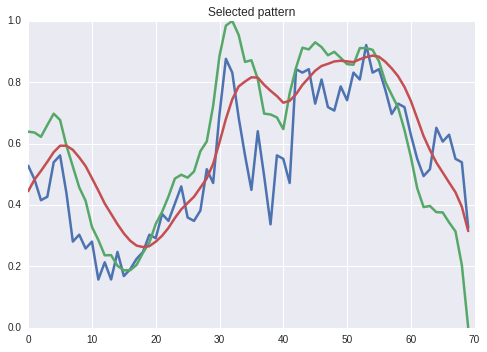

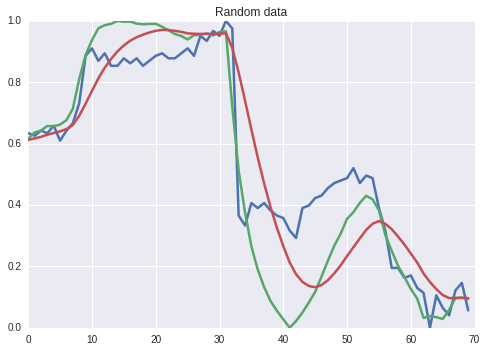

In [590]:
r = np.random.choice(range(len(real_data)))
plt.plot(real_data[r])
plt.title("Selected pattern")
plt.show()
plt.plot(fake_data[r])
plt.title("Random data")
plt.show()

In [591]:
data = zip(np.concatenate((fake_data,real_data)),
#            np.array([[-1,1]]*len(fake_data) + [[1,-1]]*len(real_data)).astype(np.int32)
           np.array([[-1]]*len(fake_data) + [[1]]*len(real_data)).astype(np.int32)
          )

In [592]:
l = int(len(data) * 0.8)
np.random.shuffle(data)
train , test = data[:l] , data[l:]

In [593]:
class Train(chainer.Chain):
    def __init__(self, predictor):
        super(Train, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
#         self.loss = F.sigmoid_cross_entropy(y, t) # softmax
        self.loss = F.mean_squared_error(y, t) # softmax
        return self.loss

In [594]:
def eval_loss(data,eval_on=10):
    sum_loss = 0
    for i in range(0, eval_on):
        r_index = np.random.randint(len(data))
        _example,_label = data[r_index][0], data[r_index][1]
        example = Variable(np.reshape(_example,(1,1,_example.shape[0],1)))
        label = Variable(np.array([_label]).astype(np.float32)) #.astype(np.float32)
        loss = t_cnn( example,label )

        sum_loss += loss.data
    mean_loss = sum_loss / eval_on
    return mean_loss

def eval_accuracy(data,eval_on=10):
    sum_loss = 0.
    for i in range(0, eval_on):
        r_index = np.random.randint(len(data))
        _example,_label = data[r_index][0], data[r_index][1]
        example = Variable(np.reshape(_example,(1,3,_example.shape[0],1)))
        pred = cnn( example ).data
        sum_loss += 1 if np.sign(_label[0])==np.sign(pred[0,0]) else 0
    mean_loss = sum_loss / eval_on
    return mean_loss

def eval_accuracy(data,eval_on=10,batch_size=50):
    sum_loss = 0.
    for i in range(0, eval_on):        
        _examples = []
        _labels = []
        for b in range(batch_size):
            r_index = np.random.randint(len(data))
            _example,_label = data[r_index][0], data[r_index][1]
            _examples.append(np.reshape(_example,(3,_example.shape[0],1)))
            _labels.append(_label)
            
        example = Variable(np.array(_examples))
#         example.to_gpu()
        
        pred = cnn( example )
#         pred.to_cpu()
        
        for idxi,i in enumerate(_labels):
            sum_loss += 1 if np.sign(_labels[idxi])==np.sign(pred.data[idxi,0]) else 0
    mean_loss = sum_loss / (eval_on*batch_size)
    return mean_loss



#### GPU training

In [595]:
def eval_accuracy(data,eval_on=10,batch_size=50):
    sum_loss = 0.
    for i in range(0, eval_on):        
        _examples = []
        _labels = []
        for b in range(batch_size):
            r_index = np.random.randint(len(data))
            _example,_label = data[r_index][0], data[r_index][1]
            _examples.append(np.reshape(_example,(3,_example.shape[0],1)))
            _labels.append(_label)
            
        example = Variable(np.array(_examples))
        example.to_gpu()
        
        pred = cnn( example )
        pred.to_cpu()
        
        for idxi,i in enumerate(_labels):
            sum_loss += 1 if np.sign(_labels[idxi])==np.sign(pred.data[idxi,0]) else 0
    mean_loss = sum_loss / (eval_on*batch_size)
    return mean_loss

In [596]:
cnn = CNN_1D()
t_cnn = Train(cnn)

optimizer = optimizers.Adam()
optimizer.setup(t_cnn)

In [597]:
%%time
cnn.to_gpu()
t_cnn.to_gpu()

n_epoch = 100
batch_size = 200

for epoch in range(n_epoch):
    cnn.zerograds()
    
    _examples = []
    _labels = []
    for b in range(batch_size):
        r_index = np.random.randint(len(train))
        _example,_label = train[r_index][0], train[r_index][1]
        _examples.append(np.reshape(_example,(3,_example.shape[0],1)))
        _labels.append(np.array(_label).astype(np.float32))
        # np.reshape(_example,(1,1,_example.shape[0],1))
        
    example = Variable(np.array(_examples))
    label = Variable(np.array(_labels)) #.astype(np.float32)
#     t_cnn( Variable(ppp),Variable(np.reshape(label,(1,1)) ))
    example.to_gpu()
    label.to_gpu()
    
    optimizer.update(t_cnn,example,label)
    
    if epoch==0 or epoch%10==0 or epoch==n_epoch-1:
        print("%s: train %0.2f , test %0.2f" %(str(epoch).ljust(10),
                                               eval_accuracy(train,eval_on = 1,batch_size=200),
                                               eval_accuracy(test, eval_on = 1,batch_size=200)))

0         : train 0.52 , test 0.48
10        : train 0.47 , test 0.51
20        : train 0.66 , test 0.61
30        : train 0.74 , test 0.73
40        : train 0.85 , test 0.74
50        : train 0.84 , test 0.89
60        : train 0.92 , test 0.90
70        : train 0.94 , test 0.89
80        : train 0.93 , test 0.83
90        : train 0.99 , test 0.84
99        : train 0.96 , test 0.82
CPU times: user 9.12 s, sys: 36 ms, total: 9.16 s
Wall time: 9.13 s


In [598]:
eval_accuracy(train,eval_on=5,batch_size=200),eval_accuracy(test,eval_on=5,batch_size=200)

(0.966, 0.81225)

In [599]:
cnn.to_cpu()
t_cnn.to_cpu()

[1] [ 0.78031397]
ok


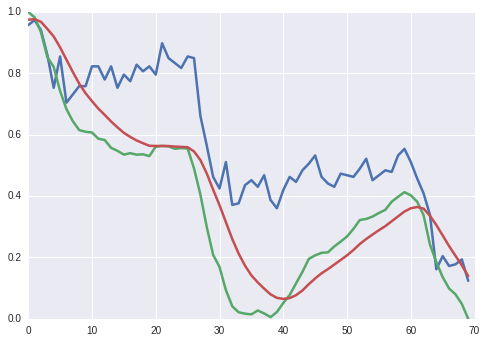

In [600]:
r_index = np.random.randint(len(test))
_example,_label = test[r_index][0], test[r_index][1]
example = Variable(np.reshape(_example,(1,3,_example.shape[0],1)))
# label = Variable(np.array([_label]))
pred = cnn( example ).data
print(_label, pred[0])
print("ok" if np.sign(_label[0])==np.sign(pred[0,0]) else "WRONG")
plt.plot(_example)
plt.show()

[-1] [-0.72044641]
ok


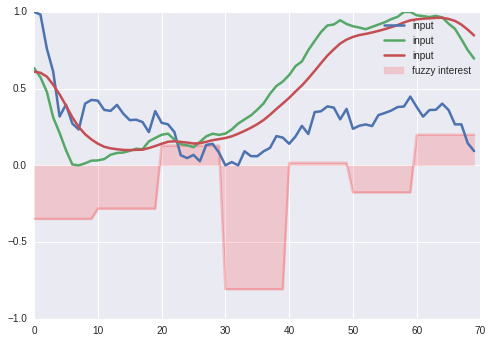

In [609]:
sh = test
r_index = np.random.randint(len(sh))
_example,_label = sh[r_index][0], sh[r_index][1]
example = Variable(np.reshape(_example,(1,3,_example.shape[0],1)))
pred = cnn( example ).data
# pred[10:20]=0
impact = []
for i in range(5,len(_example),10):
    _mod = copy.deepcopy(_example)
    _mod[i-5:i+5]  = 0
    example = Variable(np.reshape(_mod,(1,3,_mod.shape[0],1)))
    _pred = cnn( example ).data
    impact.append(pred - _pred[0,0])
    

print(_label, pred[0])
print("ok" if np.sign(_label[0])==np.sign(pred[0,0]) else "WRONG")

# y = center(np.repeat(impact,4))#/4 - 0.5
y = np.repeat(impact,10)
# y = center(np.array(impact))/4 - 0.5

plt.plot(_example,label="input")
plt.plot(y,color="r",alpha=0.2,zorder=1)
plt.fill_between(range(len(_example)),y,[0]*len(_example),color="r",alpha=0.15,zorder=1,label="fuzzy interest")
plt.legend()
plt.show()

In [1023]:
# golden_and_dead_cross/year2014_train.json

---

---

---


The `golden_and_dead_cross` directory is based on `EURUSD` / `5Min` .

[3:13]  
* `year2014_train.json` : the collection of only positive data
* `year2014_train.neg.json` : the collection of only negative data
* `year2014_train.posneg.json` : the collection of positive and negative data
* `year2014_train.negpos.json` : the collection of inverted data (positive and negative is swapped)

As I know, following is `EURUSD` / `5Min`
* list.json
* `beginner` directory

In [10]:
from tseries.converter import Converter
from tseries.indicators import get_functions

# try:
#     import cupy as xp
# except ImportError:
#     xp = np

# import logging
# logger = logging.getLogger(__name__)


def build_dataset(model_params, dataset, justify_right=False):

    # generate feature converter based on the model_params
    scale_factor = Converter.calc_price2pips_factor(model_params)
    converter = Converter(
        get_functions(
            model_params['features'],
            model_params['timeframe'],
            model_params['version'],
        ), scale_factor)

    # build the dataset
    train_candles, test_candles = preprocess.get_samples(
        get_pandadb()[get_table_name(
            model_params['symbol'],
            model_params['timeframe'])],
        dataset,
        converter=converter,
        align=model_params['config']['align'],
        shuffle=False,
        symbol=model_params['symbol'],
        justify_right=justify_right
    )

In [11]:
from ml import preprocess
from histdata import get_pandadb, get_table_name
from tseries.converter import Converter
from tseries.indicators import get_functions

from matplotlib.finance import candlestick2_ohlc

In [12]:
def plot_candles(c):
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)


    candlestick2_ohlc(ax, c[:,0], c[:,1], c[:,2], c[:,3], width=0.8, colorup='mediumseagreen', colordown='crimson', alpha=0.9)
    # ax.autoscale_view()
    fig.tight_layout()

    plt.show()

In [308]:
def _only_selected(cand):
    t = []
    for i in cand:
        if not i["y"][0]>0:
            continue
        t.append(i["x"])
    return np.array(t)
def _partial_normalize(cand):
    c = np.array([i["x"] for i in cand])
    c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
    c[:,[4,5]] = center_01(c[:,[4,5]])
    c[:,[6,7]] = center_01(c[:,[6,7]])
    c[:,[8,9]] = center_01(c[:,[8,9]])
    return c
def _only_selected_partial_normalize(cand):
    t = []
    for i in cand:
        if not i["y"][0]>0:
            continue
        t.append(i["x"])
    c = np.array(t)
    c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
    c[:,[4,5]] = center_01(c[:,[4,5]])
    c[:,[6,7]] = center_01(c[:,[6,7]])
    c[:,[8,9]] = center_01(c[:,[8,9]])
    return c

In [13]:
mp = load_json("/project/exp/list_mp_no_norm.json")
# mp

In [307]:
# [(i["id"],i["indicator_type"]) for i in mp["features"]]
indicators = [str(i["id"]) for i in mp["features"]]

In [14]:
dataset = load_json("/project/exp/golden_and_dead_cross/year2014_train.json")

# dataset = load_json("/project/exp/beginner/selected_stochastic.json")

# dataset = load_json("/project/exp/eurusd_15m_ma50_one_top_over_ma.json")

In [272]:
import pandas as pd
list_of_datasets = pd.read_csv("./../../data/List_of datasets_2016_06_17.csv")

list_of_datasets["len json"] = map(lambda row: len(json.loads(row)["data"]) , list_of_datasets["json"])

In [273]:
list_of_datasets.sort_values("sharpe_ratio", ascending=False, inplace=True)
list_of_datasets.index = range(len(list_of_datasets))
list_of_datasets.head(20)

,id,json,sharpe_ratio,net_profit,symbol,timeframe,side,key,len json
0,4740,"{""version"": 1, ""data"": [{""start"": ""2016/05/04 ...",0.141389,1740.3,USDJPY,15Min,short,20160519-052759_slk80-3-app-1-www_8ac05b8c,9
1,1299,"{""version"": 1, ""data"": [{""start"": ""2016/02/24 ...",0.131104,1279.8,USDJPY,15Min,long,20160311-161039_slk80-3-app-1-www_80675366,3
2,4957,"{""version"": 1, ""data"": [{""start"": ""2016/05/18 ...",0.119914,1450.2,USDJPY,5Min,short,20160523-063551_slk80-4-app-2-www_cfdda6a6,25
3,4067,"{""version"": 1, ""data"": [{""start"": ""2016/04/26 ...",0.119648,3357.7,EURUSD,5Min,short,20160428-153058_slk80-4-app-2-www_75d31351,7
4,4392,"{""version"": 1, ""data"": [{""start"": ""2016/05/03 ...",0.118314,3046.8,USDCHF,5Min,long,20160506-120633_slk80-3-app-1-www_b72d65f3,6
5,4840,"{""version"": 1, ""data"": [{""start"": ""2016/06/03 ...",0.106953,2228.2,USDJPY,5Min,long,20160329-163946_slk80-4-app-2-www_75b192b3,27
6,2821,"{""version"": 1, ""data"": [{""start"": ""2016/03/17 ...",0.096281,1621.0,USDJPY,5Min,long,20160322-035818_slk80-3-app-1-www_c2cca285,4
7,4440,"{""version"": 1, ""data"": [{""start"": ""2016/04/21 ...",0.092067,2941.4,EURJPY,5Min,short,20160508-051608_slk80-3-app-1-www_944fab02,7
8,4974,"{""version"": 1, ""data"": [{""start"": ""2016/02/24 ...",0.091675,2485.8,USDJPY,15Min,long,20160520-010139_slk80-3-app-1-www_a6e846a4,20
9,2333,"{""version"": 1, ""data"": [{""start"": ""2016/01/15 ...",0.091472,2226.2,USDJPY,1H,short,20160314-170208_slk80-4-app-2-www_9fcaec32,152


In [555]:
c = 9
cc = list_of_datasets[c:c+1]
dataset = json.loads(cc["json"].values[0])
mp['symbol'] = cc["symbol"].values[0]
mp['timeframe'] = cc["timeframe"].values[0]
mp['version'] =  dataset["version"]

In [556]:
scale_factor = Converter.calc_price2pips_factor(mp)

In [557]:
converter = Converter(
    get_functions(
        mp['features'],
        mp['timeframe'],
        mp['version'],
    ), scale_factor)

In [558]:
%%time
train_candles, test_candles = preprocess.get_samples(
    get_pandadb()[get_table_name(
        mp['symbol'],
        mp['timeframe'])],
    [{u'end': u'2014/03/23 17:45', u'label': [], u'start': u'2012/03/23 15:00'}],
    converter=converter,
    align=40000, #mp['config']['align'],
    shuffle=False,
    symbol=mp['symbol'],
    justify_right=True
)
clean_data_fat = np.array([[i["x"] for i in j] for j in train_candles])

CPU times: user 288 ms, sys: 12 ms, total: 300 ms
Wall time: 547 ms


In [559]:
%%time
train_candles, test_candles = preprocess.get_samples(
    get_pandadb()[get_table_name(
        mp['symbol'],
        mp['timeframe'])],
    dataset["data"],
    converter=converter,
    align=70, #mp['config']['align'],
    shuffle=False,
    symbol=mp['symbol'],
    justify_right=False
)

CPU times: user 956 ms, sys: 0 ns, total: 956 ms
Wall time: 956 ms


In [560]:
len(train_candles)

152

In [561]:
# clean_data = np.array([[i["x"] for i in j] for j in train_candles])
# clean_data = np.array([_only_selected(j) for j in train_candles])
clean_data = np.array([_partial_normalize(j) for j in train_candles])
# clean_data = np.array([_only_selected_partial_normalize(j) for j in train_candles])
yyy = np.array([[i["y"] for i in j] for j in train_candles])

In [562]:
# !pip install pandas_profiling
# import pandas_profiling
# pandas_profiling.ProfileReport(pd.DataFrame(data=[len(i) for i in clean_data]))

In [563]:
#plot_candles(clean_data[0])

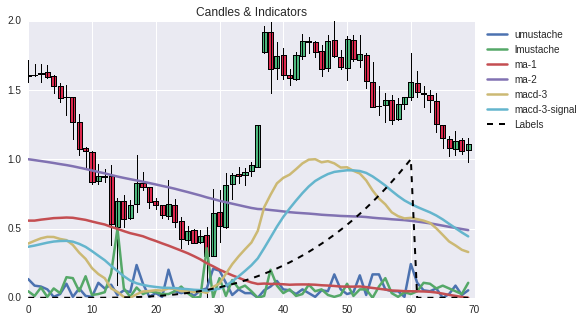

In [569]:
r = np.random.choice(len(clean_data))
c = copy.deepcopy(clean_data[r])
c[:,[0,1,2,3]] = c[:,[0,1,2,3]] *2
c[:,[4,5]] = c[:,[4,5]] /2
c[:,[6,7]] = c[:,[6,7]]
c[:,[8,9]] = c[:,[8,9]]

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)


candlestick2_ohlc(ax, c[:,0], c[:,1], c[:,2], c[:,3], width=0.8,
                  colorup='mediumseagreen', colordown='crimson', alpha=0.9)

for i in range(4,len(c[0])):
    plt.plot(c[:,i],label=indicators[i])
plt.plot(yyy[r],'k--',label="Labels",linewidth=2)
plt.title("Candles & Indicators")
plt.legend(loc=1, bbox_to_anchor=(1.25, 1), ncol=1)

ax.set_xlim(xmin=0)

plt.show()

---

---

---

In [956]:
in_size = 100
h_size = 25
h_size2 = 50
# h_size3 = 600

out_size = in_size
class AutoEnc(chainer.Chain):
    def __init__(self):
        super(AutoEnc, self).__init__(
            l0 = L.Linear(in_size,h_size2),
            l2 = L.Linear(h_size2,h_size),
            l3 = L.Linear(h_size,h_size2),
            l5 = L.Linear(h_size2,out_size),
#             l0 = L.Linear(in_size,h_size3),
#             l1 = L.Linear(h_size3,h_size2),
#             l2 = L.Linear(h_size2,h_size),
#             l3 = L.Linear(h_size,h_size2),
#             l4 = L.Linear(h_size2,h_size3),
#             l5 = L.Linear(h_size3,out_size),
        )
        
    def __call__(self, x):
        h = F.tanh(self.l0(x))
        h = F.tanh(self.l2(h))
        h = F.tanh(self.l3(h))
        h = F.tanh(self.l5(h))
#         h = F.sigmoid(self.l0(x))
#         h = F.sigmoid(self.l1(h))
#         h = F.sigmoid(self.l2(h))
#         h = F.sigmoid(self.l3(h))
#         h = F.sigmoid(self.l4(h))
#         h = F.sigmoid(self.l5(h))
        return h
    
class Train(chainer.Chain):
    def __init__(self, predictor):
        super(Train, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = mean_error(y, t)
#         self.accuracy = F.accuracy(y, t)
        return self.loss

class Train_contrastive(chainer.Chain):
    def __init__(self, predictor):
        super(Train_contrastive, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
#         print(np.shape(y.data))
#         label = np.zeros(np.shape(y.data)[0])
        
#         for idxi,i in enumerate(y.data):
#             eq = True
#             for idxj,j in enumerate(i):
# #                 if y.data[idxi, idxj] == t.data[idxi, idxj]:
# #                     label[idxi, idxj] = 1
#                 if y.data[idxi, idxj] != t.data[idxi, idxj]:
#                     eq = False
#             if eq:
#                 label[idxi] = 1
        
        self.loss = F.mean_squared_error(y, t)
#         self.loss = F.contrastive(y, t, Variable(label.astype(np.int32)))
#         self.loss = F.cross_covariance(y, t)*0.0001 + F.mean_squared_error(y, t)
#         self.loss = F.mean_squared_error(y, t)
        return self.loss

In [957]:
ae = AutoEnc()
tae = Train_contrastive(ae)
tae.to_gpu()
opti = optimizers.Adam()
opti.setup(tae)

In [959]:
#%%time
n_epoch = 1000
batch_size = 100

for epoch in range(n_epoch):
    ba = []
    ba2 = []
    for i in range(batch_size):
        ma = np.random.randint(0,len(all_val)-(in_size))
#         inp = np.concatenate((center(all_val[ma:ma+in_size]),
#                              norm_and_center(all_val[ma:ma+(in_size+1)])
#                             ))
        inp = norm_and_center(all_val[ma:ma+in_size+1])
        ba.append(inp.astype(np.float32))

    
    v = Variable(cuda.to_gpu(np.array(ba)))
#     v_out = Variable(cuda.to_gpu(np.array(ba2)))
#     v = Variable(np.array(ba))
    
    opti.update(tae,v,v)
    if epoch==0 or epoch%(n_epoch/20)==0 or epoch==n_epoch-1:
        print("%s: %0.9f" %(str(epoch).ljust(10),tae.loss.data))

0         : 0.079519711
100       : 0.078348659
200       : 0.081630409
300       : 0.081015773
400       : 0.078227736
500       : 0.081589282
600       : 0.079601988
700       : 0.080021054
800       : 0.080190599
900       : 0.079753555
1000      : 0.081974924
1100      : 0.077046268
1200      : 0.080480106
1300      : 0.077491365
1400      : 0.079150856
1500      : 0.076476730
1600      : 0.083291396
1700      : 0.078388669
1800      : 0.078637674
1900      : 0.076469719
1999      : 0.076323636


[ 0.14613178  0.09727522 -0.24473497  0.9399367   0.28046814 -0.04924997
  0.90308452 -0.72065198  0.42704511  0.18276991]
[ 0.24341851  0.31210545  0.08918103  0.33857918  0.26868463 -0.11299844
  0.58684075 -0.29261008  0.71104687 -0.02799233]


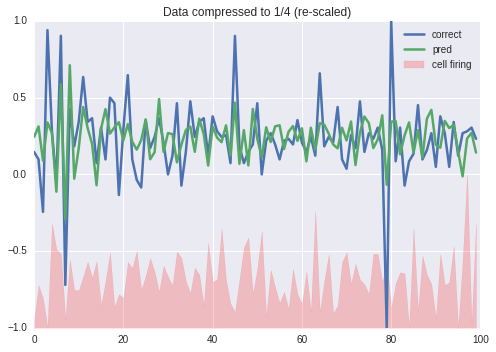

(Higher is better)
Inv. covariance:   269.011142827
Inv. correlation:  0.133885


In [1135]:
ma = np.random.randint(0,len(all_val)-(in_size))
inp = norm_and_center(all_val[ma:ma+(in_size+1)])
# inp2 = np.concatenate((center(all_val[ma:ma+in_size]),
#                              norm_and_center(all_val[ma:ma+(in_size+1)])
#                             ))
v = Variable(cuda.to_gpu(np.array([inp.astype(np.float32)])))
# v = Variable(np.array([inp.astype(np.float32)]))


ret = ae(v)

print(inp[:10])
print(ret.data[0][:10])

su = np.sum(cuda.to_cpu(ae.l0.W.data).T,axis=1)

plt.plot(inp,label="correct")
plt.plot(cuda.to_cpu(ret.data)[0],label="pred")
# plt.plot(su,alpha=0.5,fillstyle="bottom",label="ex")
plt.fill_between(range(100),(center(su)+1)/2 -1,[-1]*100,color="r",alpha=0.2,zorder=1,label="cell firing")
plt.legend()
plt.title("Data compressed to 1/4 (re-scaled)")
plt.show()


x = np.array(zip(inp,cuda.to_cpu(ret.data)[0]))

xx = map(lambda x: [x[0],x[1].tolist()], x)

cova = np.cov(xx)
# print(cova[0][1])
print("(Higher is better)")
print("Inv. covariance:  ",1/(np.sum(cova)/np.sum(np.shape(cova))))
print("Inv. correlation: ",(1/np.correlate(inp,cuda.to_cpu(ret.data)[0]))[0])

In [1013]:
ae.l0(v).data[0]

array([ 0.09046914,  0.06891366,  0.18637428,  0.03789999,  0.32173747,
       -0.16829924, -0.19929126,  0.13154386,  0.49780136,  0.54685652,
        0.10964749,  0.13242628, -0.10634674,  0.23858622, -0.42236158,
        0.34668338, -0.01765037, -0.23904039,  0.19271323, -0.06891738,
       -0.44082975,  0.05053517,  0.24479896,  0.15586013, -0.03582393,
       -0.1414412 , -0.0392537 ,  0.19534455,  0.1980195 ,  0.01748553,
       -0.14061546, -0.1146475 , -0.19260731, -0.08392124, -0.00226129,
       -0.06934342, -0.38787735, -0.26715416,  0.03045877, -0.00888004,
       -0.00157548,  0.04113426, -0.04155827, -0.06009218,  0.31067041,
       -0.06400891, -0.26977402, -0.02321906,  0.43902707,  0.04194541], dtype=float32)

In [1012]:
su

array([-0.76344997, -0.12239879, -0.3743214 , -0.91069198,  1.02260554,
        0.54596758,  0.46850577, -0.76191646,  0.35370865, -0.21014595,
       -0.22101504,  0.04053895,  0.31444529,  0.01296253,  0.32189378,
       -0.50228518, -0.04563873,  0.48079956, -0.53426927, -0.29273874,
       -0.35871208,  0.31033736,  0.19483574,  0.51602322, -0.2143192 ,
        0.0530674 ,  0.38084313,  0.12206851, -0.24826474,  0.23616631,
        0.03401733, -0.13206199,  0.50632966,  0.38490397, -0.05212657,
       -0.27169567,  0.20356125,  0.07264572, -0.5038507 ,  0.66516221,
       -0.06230236, -0.01107755,  0.93286228, -0.03270606, -0.46880949,
       -0.62574428, -0.0185521 ,  0.58606142,  0.76730323, -0.28324708,
        0.18205348,  0.88391691, -0.71182036,  0.15870056, -0.16535906,
       -0.45628813, -0.25119033, -0.56723499,  0.17572922, -0.29514197,
       -0.4787963 ,  0.12560385, -0.61803418,  1.25860703, -0.62739921,
       -0.04622063,  0.44917187, -0.64959514, -0.50008661,  0.30

In [1137]:
a = np.array([1,2,3])

In [1138]:
np.repeat(a,2)

array([1, 1, 2, 2, 3, 3])

In [1062]:
g = ae.links()

In [1077]:
t = []
for i in ae.namedlinks():
    print(i)
    if len(i[0])>1:
        t.append(i)

('/', <__main__.AutoEnc object at 0x7f12c2e02b50>)
('/l5', <chainer.links.connection.linear.Linear object at 0x7f12c2e6d050>)
('/l2', <chainer.links.connection.linear.Linear object at 0x7f12c3ac4210>)
('/l3', <chainer.links.connection.linear.Linear object at 0x7f12c2e21610>)
('/l0', <chainer.links.connection.linear.Linear object at 0x7f12c2e21410>)


In [1078]:
t.sort(key=lambda x: x[0])
t

[('/l0', <chainer.links.connection.linear.Linear at 0x7f12c2e21410>),
 ('/l2', <chainer.links.connection.linear.Linear at 0x7f12c3ac4210>),
 ('/l3', <chainer.links.connection.linear.Linear at 0x7f12c2e21610>),
 ('/l5', <chainer.links.connection.linear.Linear at 0x7f12c2e6d050>)]

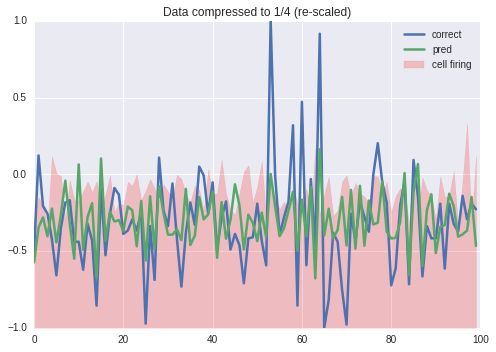

In [1153]:
ma = np.random.randint(0,len(all_val)-(in_size))
inp = norm_and_center(all_val[ma:ma+(in_size+1)])
v = Variable(cuda.to_gpu(np.array([inp.astype(np.float32)])))

ret = ae(v)




# x = np.array(zip(inp,cuda.to_cpu(ret.data)[0]))

# xx = map(lambda x: [x[0],x[1].tolist()], x)

# cova = np.cov(xx)
# # print(cova[0][1])
# print("(Higher is better)")
# print("Inv. covariance:  ",1/(np.sum(cova)/np.sum(np.shape(cova))))
# print("Inv. correlation: ",(1/np.correlate(inp,cuda.to_cpu(ret.data)[0]))[0])


links = []
for i in ae.namedlinks():
    if len(i[0])>1:
        links.append(i)
for link_name,link in sorted(links,key=lambda x: x[0]):
#     print(type(i))
#     print(link_name[1:], link.W.data.shape)
    v = link(v).data
    # YlOrRd, black is highest
    # YlGnBu, yellow highest
    # viridis, yellow highest
    to_plot = np.repeat(cuda.to_cpu(v)[0], 100/link.W.data.shape[0])
    sns.heatmap([to_plot], cmap="viridis", square=True,
            xticklabels=False,
            yticklabels=False,
           cbar=False)
    plt.show()
    v = Variable(cuda.to_gpu(v))
    
    
su = np.sum(cuda.to_cpu(ae.l0.W.data).T,axis=1)

plt.plot(inp,label="correct")
plt.plot(cuda.to_cpu(ret.data)[0],label="pred")
# plt.plot(su,alpha=0.5,fillstyle="bottom",label="ex")
plt.fill_between(range(100),center(su)/3,[-1]*100,color="r",alpha=0.2,zorder=1,label="cell firing")
plt.legend()
plt.title("Data compressed to 1/4 (re-scaled)")
plt.show()

In [1141]:
100/link.W.data.shape[0]

2

In [1144]:
ma = np.random.randint(0,len(all_val)-(in_size))
inp = norm_and_center(all_val[ma:ma+(in_size+1)])
v = Variable(cuda.to_gpu(np.array([inp.astype(np.float32)])))


links = []
for i in ae.namedlinks():
    if len(i[0])>1:
        links.append(i)
for link_name,link in sorted(links,key=lambda x: x[0]):
#     print(type(i))
#     print(link_name[1:], link.W.data.shape)
    v = link(v).data
    # YlOrRd, black is highest
    # YlGnBu, yellow highest
    # viridis, yellow highest
    to_plot = np.repeat(cuda.to_cpu(v)[0], 100/link.W.data.shape[0])
    sns.heatmap([to_plot], cmap="viridis", square=True,
            xticklabels=False,
            yticklabels=False,
           cbar=False)
    plt.show()
    v = Variable(cuda.to_gpu(v))

In [1083]:
len(ae.l0(v).data[0])

50

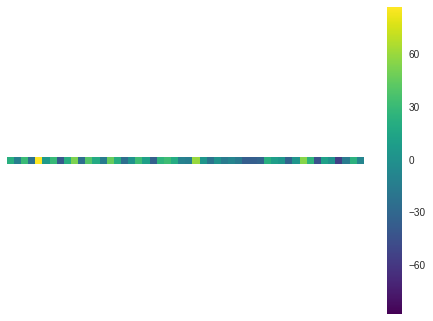

In [1125]:
su = np.sum(cuda.to_cpu(ae.l0.W.data).T,axis=1)
sns.heatmap([cuda.to_cpu(ae.l0(v).data)[0]],
            cmap="viridis",
            square=True,
            xticklabels=False,
            yticklabels=False,
)
# sns.heatmap([su]).set(xticks=[],yticks=[])
plt.show()

In [859]:
in_size = 1000
h_size = 250
h_size2 = 400
h_size3 = 700

out_size = in_size
class AutoEnc(chainer.Chain):
    def __init__(self):
        super(AutoEnc, self).__init__(
            l0 = L.Linear(in_size,h_size2),
            l2 = L.LSTM(h_size2,h_size),
            l3 = L.LSTM(h_size,h_size2),
            l5 = L.Linear(h_size2,out_size),
#             l0 = L.Linear(in_size,h_size3),
#             l1 = L.Linear(h_size3,h_size2),
#             l2 = L.LSTM(h_size2,h_size),
#             l3 = L.Linear(h_size,h_size2),
#             l4 = L.Linear(h_size2,h_size3),
#             l5 = L.Linear(h_size3,out_size),
        )
        
    def reset_state(self):
        self.l2.reset_state()
        self.l3.reset_state()
        
    def __call__(self, x):
        h = F.tanh(self.l0(x))
        h = F.tanh(self.l2(h))
        h = F.tanh(self.l3(h))
        h = F.tanh(self.l5(h))
#         h = F.tanh(self.l0(x))
#         h = F.tanh(self.l1(h))
#         h = F.tanh(self.l2(h))
#         h = F.tanh(self.l3(h))
#         h = F.tanh(self.l4(h))
#         h = F.tanh(self.l5(h))
        return h
    
class Train(chainer.Chain):
    def __init__(self, predictor):
        super(Train, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.mean_squared_error(y, t)
#         self.accuracy = F.accuracy(y, t)
        return self.loss

In [860]:
L.LSTM

chainer.links.connection.lstm.LSTM

In [862]:
ae = AutoEnc()
tae = Train(ae)
tae.to_gpu()
opti = optimizers.Adam()
opti.setup(tae)

In [863]:
ae.reset_state()

In [915]:
#%%time
n_epoch = 10000
batch_size = 100

ae.reset_state()


for epoch in range(n_epoch):
#     ba = []
#     for i in range(batch_size):
#         ma = np.random.randint(0,len(all_val)-(in_size+1))
#         inp = norm_and_center(all_val[ma:ma+in_size+1])   
#         ba.append(inp.astype(np.float32))

    ae.reset_state()

    ma = np.random.randint(0,len(all_val)-(in_size+1))
    inp = norm_and_center(all_val[ma:ma+in_size+1]) 
    ba = np.array([[i] for i in inp]).astype(np.float32).T
    
    v = Variable(cuda.to_gpu(np.array(ba)))
    
    opti.update(tae,v,v)
    if epoch==0 or epoch%(n_epoch/20)==0 or epoch==n_epoch-1:
        print("%s: %0.9f" %(str(epoch).ljust(10),tae.loss.data))

0         : 0.034014281
500       : 0.059305616
1000      : 0.017694764
1500      : 0.024822626
2000      : 0.055266380
2500      : 0.004791535
3000      : 0.019841157
3500      : 0.028654182
4000      : 0.027645271
4500      : 0.030106673
5000      : 0.030367998
5500      : 0.039066449
6000      : 0.030299069
6500      : 0.042325731
7000      : 0.036139227
7500      : 0.020557543
8000      : 0.031770591
8500      : 0.021898065
9000      : 0.002638343
9500      : 0.034405995
9999      : 0.038353320


[-0.15666932 -0.15667267 -0.20088819 -0.06824835  0.02015255 -0.06826174
 -0.06826508  0.02010237 -0.20084134 -0.20085472]
[-0.11258598 -0.1085121  -0.12179309 -0.10832338 -0.13369234 -0.14219289
 -0.13632657 -0.1349892  -0.13737531 -0.14978775]
(Higher is better)
Inv. covariance:   38.0815700497
Inv. correlation:  0.0741957


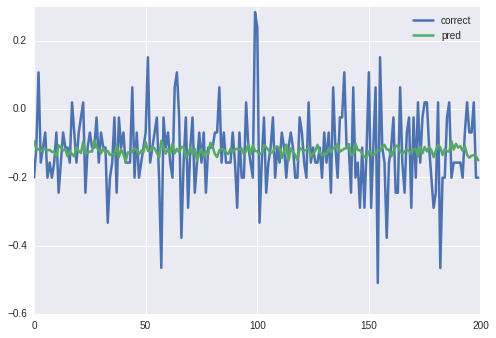

In [926]:
ae.reset_state()
# ma = np.random.randint(0,len(all_val)-(in_size+1))
# inp = norm_and_center(all_val[ma:ma+(in_size+1)])
# v = Variable(cuda.to_gpu(np.array([inp.astype(np.float32)])))

ma = np.random.randint(0,len(all_val)-(in_size+1))
inp = norm_and_center(all_val[ma:ma+in_size+1]) 
ba = np.array([[i] for i in inp]).astype(np.float32).T

v = Variable(cuda.to_gpu(np.array(ba)))

ret = ae(v)

print(inp[-10:])
print(ret.data[0][-10:])

plt.plot(inp[-200:],label="correct")
plt.plot(cuda.to_cpu(ret.data)[0][-200:],label="pred")
plt.legend()
x = np.array(zip(inp,cuda.to_cpu(ret.data)[0]))

xx = map(lambda x: [x[0],x[1].tolist()], x)

cova = np.cov(xx)
# print(cova[0][1])
print("(Higher is better)")
print("Inv. covariance:  ",1/(np.sum(cova)/np.sum(np.shape(cova))))
print("Inv. correlation: ",(1/np.correlate(inp,cuda.to_cpu(ret.data)[0]))[0])

In [349]:
sum_loss, sum_accuracy = 0, 0

for i in range(0, 1000, batch_size):
    ba=[]
    for i in range(batch_size):
        ma = np.random.randint(0,len(all_val)-(in_size+1))
        inp = norm_and_center(all_val[ma:ma+(in_size+1)])
        ba.append(inp.astype(np.float32))
    v = Variable(cuda.to_gpu(np.array(ba)))
    
    loss = tae(v, v)
    sum_loss += loss.data * batch_size
mean_loss = sum_loss / 1000
print(mean_loss)

0.0370470620692
